In [76]:
#TODO: convert to current timezone.  Currently max temps are all over the place.
# - and where are the sensors exactly?  Have they been moved over time?
# why is there no objective evidence of a cooler house despite the work we did to make it cooler?  Is it just less airconditioning?  Or is there no difference?
# could smooth graphs with EWMA?

In [81]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import gzip
import io
import datetime
from typing import List

In [25]:

# Step 1: Read the first 10,000 lines of the compressed CSV file into a DataFrame
file_path = 'data/iotitan_20241225_data_sorted.csv.gz'
with gzip.open(file_path, 'rt') as f:
    text = "\n".join([line for line in f if not (line.startswith('#') or line.startswith('File='))])

    colnames=['timestamp', 'sensor_name', 'sensor_value'] 
    #df = pd.read_csv(io.StringIO(text),nrows=10000, header=None, names=colnames)
    df = pd.read_csv(io.StringIO(text), header=None, names=colnames)


C:\Users\jon3d\AppData\Local\Temp\ipykernel_768\2967815984.py:8: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.StringIO(text), header=None, names=colnames)


In [54]:
# Step 2: Convert the 'timestamp' column to datetime format, and create additional columns
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
# Create a new 'year' column from the 'timestamp' column
df['year'] = pd.DatetimeIndex(df['timestamp']).year
# Create a new 'month' column from the 'timestamp' column
df['month'] = pd.DatetimeIndex(df['timestamp']).month
# Create a new 'day' column from the 'timestamp' column indicating the numeric day-of-month
df['day'] = pd.DatetimeIndex(df['timestamp']).day
# Create a new column 'day_of_year' which is the day of the year the sensor value was observed
df['day_of_year'] = pd.to_datetime(df['timestamp']).dt.dayofyear

In [27]:
# Step 3: convert values to numeric
df['sensor_value'] = pd.to_numeric(df['sensor_value'], errors='coerce')

In [43]:
df.head(3)

,timestamp,sensor_name,sensor_value,year,month,day
0,2019-05-12 20:55:10,iotitan/home/up_bed1/xc-4444/pir,1.0,2019,5,12
1,2019-05-12 20:55:20,iotitan/home/up_bed4/dht11/temperature,18.0,2019,5,12
2,2019-05-12 20:55:21,iotitan/home/up_bed4/dht11/humidity,60.0,2019,5,12


In [66]:
sensor_names = df['sensor_name'].unique()
sensor_names

array(['iotitan/home/up_bed1/xc-4444/pir',
       'iotitan/home/up_bed4/dht11/temperature',
       'iotitan/home/up_bed4/dht11/humidity',
       'iotitan/home/downstairs/dht22/humidity/average',
       'iotitan/home/downstairs/dht22/temperature/average',
       'iotitan/home/up_bed1/dht11/humidity/average',
       'iotitan/home/up_bed1/dht11/temperature/average',
       'iotitan/home/up_bed1/xc-4444/pir/average',
       'iotitan/home/up_bed4/dht11/humidity/average',
       'iotitan/home/up_bed4/dht11/temperature/average',
       'iotitan/home/downstairs/dht22/humidity',
       'iotitan/home/downstairs/dht22/temperature',
       'iotitan/home/up_bed1/dht11/humidity',
       'iotitan/home/up_bed1/dht11/temperature',
       'iotitan/home/up_bed1/status/LWT',
       'iotitan/home/downstairs/status/LWT',
       'iotitan/home/up_bed4/status/LWT',
       'iotitan/home/outside/radmon/cpm',
       'iotitan/home/outside/radmon/dose',
       'iotitan/home/outside/radmon/rssi',
       'iotitan/hom

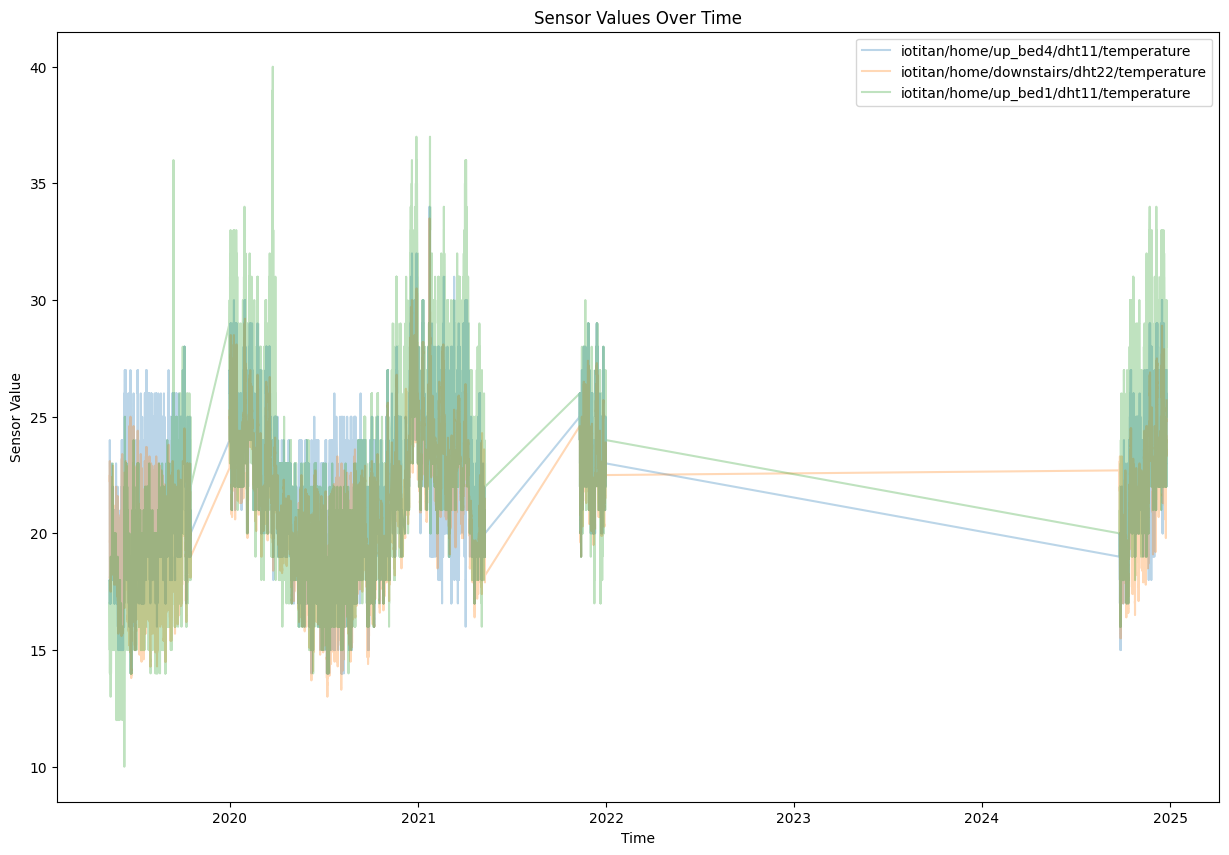

In [31]:
# Step 4: Create time series plots for each sensor
plt.figure(figsize=(15, 10))
for sensor_name in sensor_names:
    if ('temperature' in sensor_name) and ('average' not in sensor_name):
        sensor_data = df[df['sensor_name'] == sensor_name]
        plt.plot(sensor_data['timestamp'], sensor_data['sensor_value'], label=sensor_name, alpha=0.7)

plt.xlabel('Time')
plt.ylabel('Sensor Value')
plt.title('Sensor Values Over Time')
plt.legend()
plt.show()

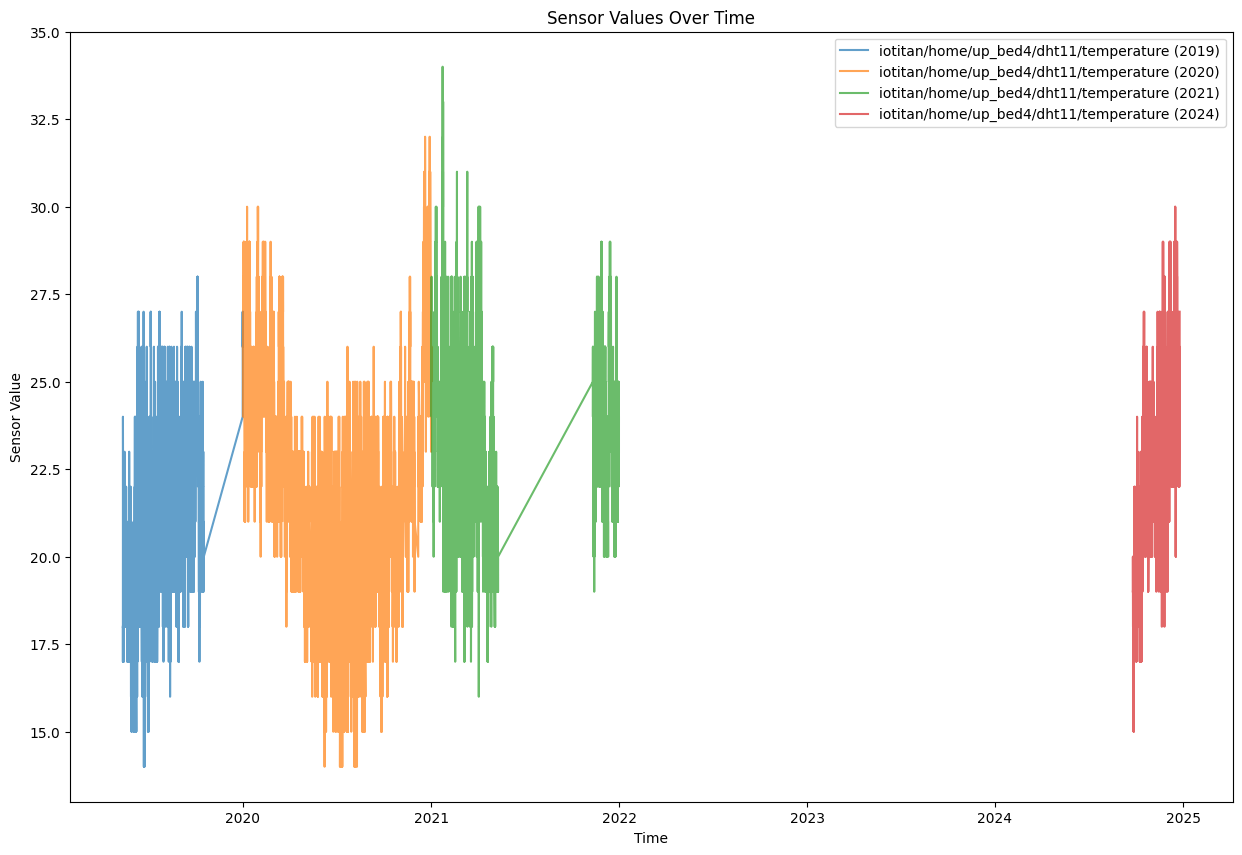

C:\Users\jon3d\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


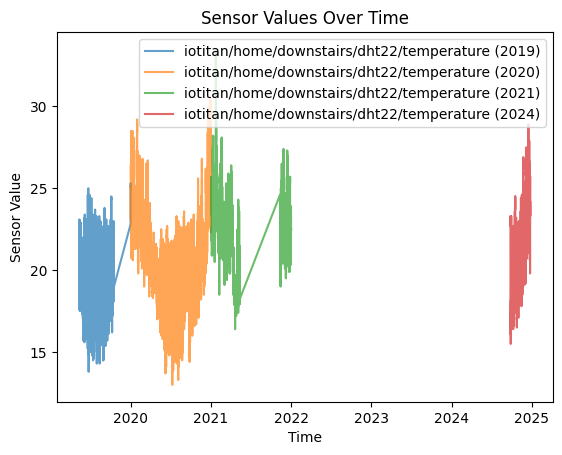

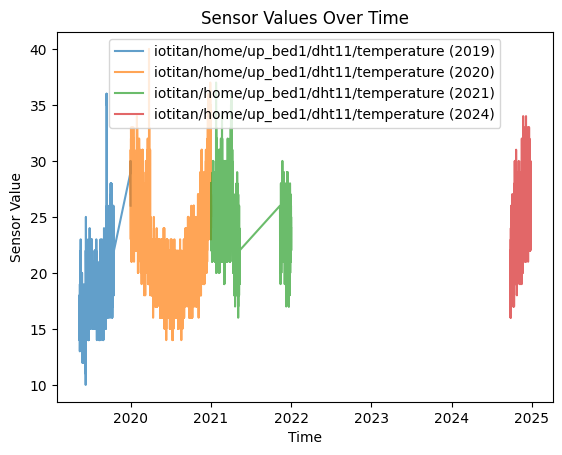

In [63]:
# Now partition the data by year
plt.figure(figsize=(15, 10))
for sensor_name in sensor_names:
    if ('temperature' in sensor_name) and ('average' not in sensor_name):
        sensor_data = df[df['sensor_name'] == sensor_name]
        years = sensor_data['year'].unique()
        for year in years:
            year_data = sensor_data[sensor_data['year'] == year]
            plt.plot(year_data['timestamp'], year_data['sensor_value'], label=f"{sensor_name} ({year})", alpha=0.7)

        plt.xlabel('Time')
        plt.ylabel('Sensor Value')
        plt.title('Sensor Values Over Time')
        plt.legend()
        plt.show()

# MAX TEMPERATURE

In [55]:
# Create a new dataframe of max value per day for each sensor
# Step 5: Group by 'sensor_name' and 'date' and calculate the max value per day
max_per_day_df = df.groupby(['sensor_name', 'year','day_of_year'])['sensor_value'].max().reset_index()

In [56]:
#max_per_day_df['day_of_year'] = datetime.datetime(max_per_day_df['year'], max_per_day_df['month'], max_per_day_df['day']).timetuple().tm_yday
#day_of_year = datetime(YEAR, MONTH, DAY).timetuple().tm_yday

In [57]:
max_per_day_df.head(4)

,sensor_name,year,day_of_year,sensor_value
0,iotitan/home/downstairs/dht22/humidity,2019,132,58.6
1,iotitan/home/downstairs/dht22/humidity,2019,133,58.4
2,iotitan/home/downstairs/dht22/humidity,2019,134,58.9
3,iotitan/home/downstairs/dht22/humidity,2019,135,58.7


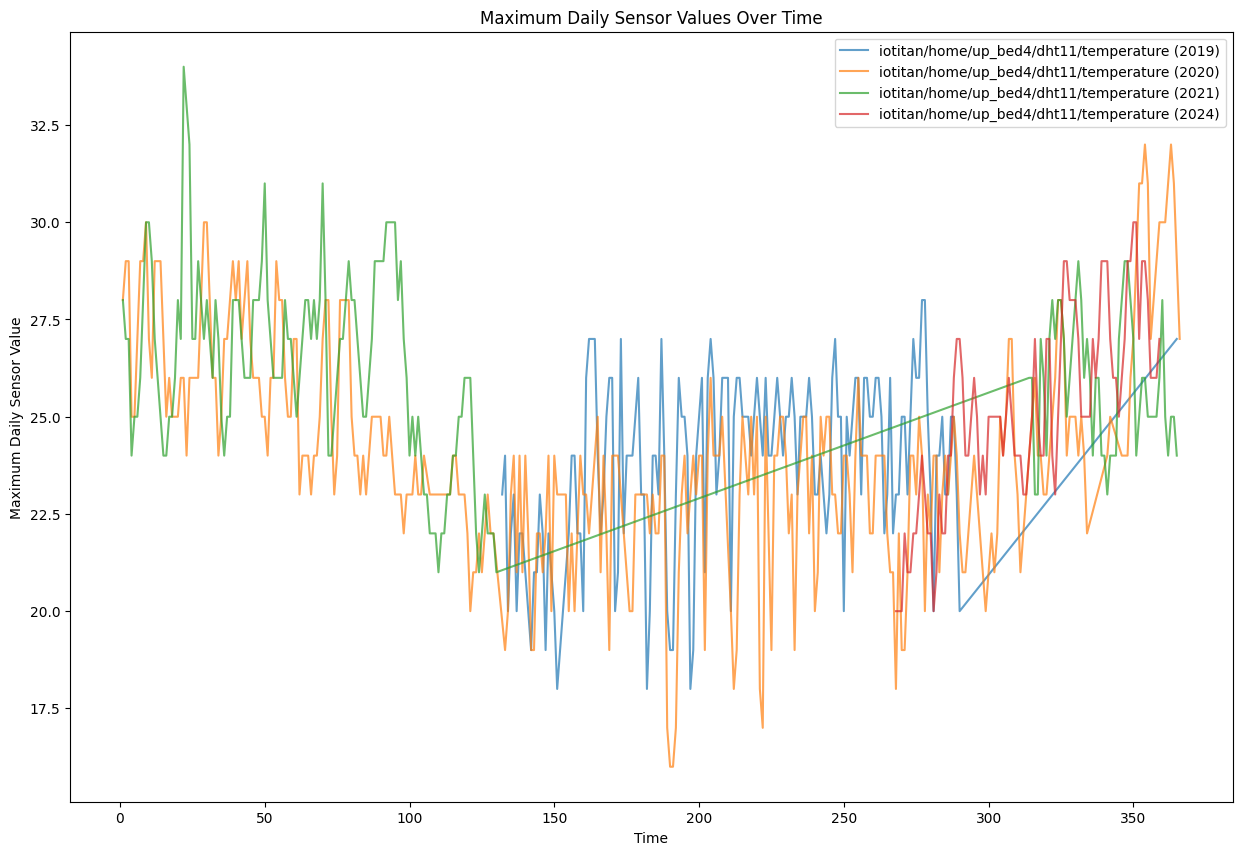

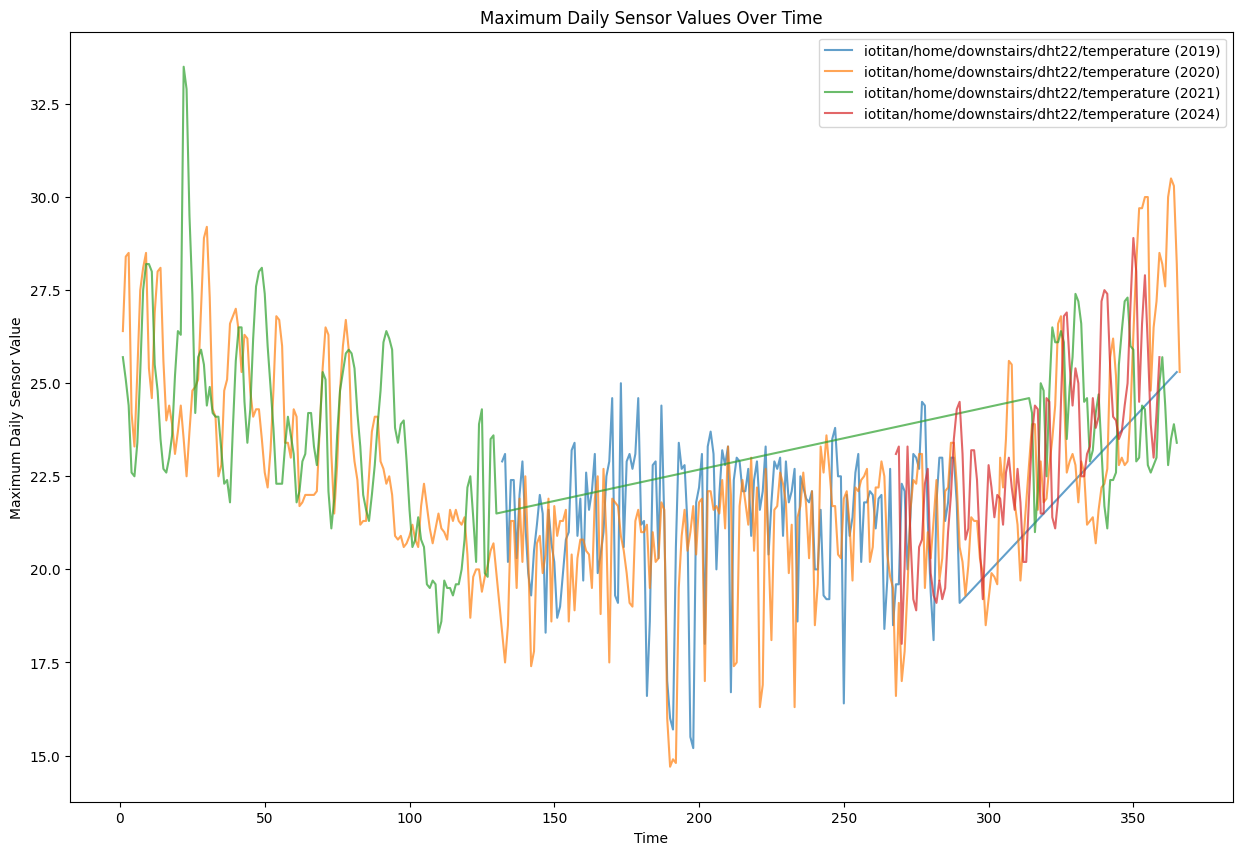

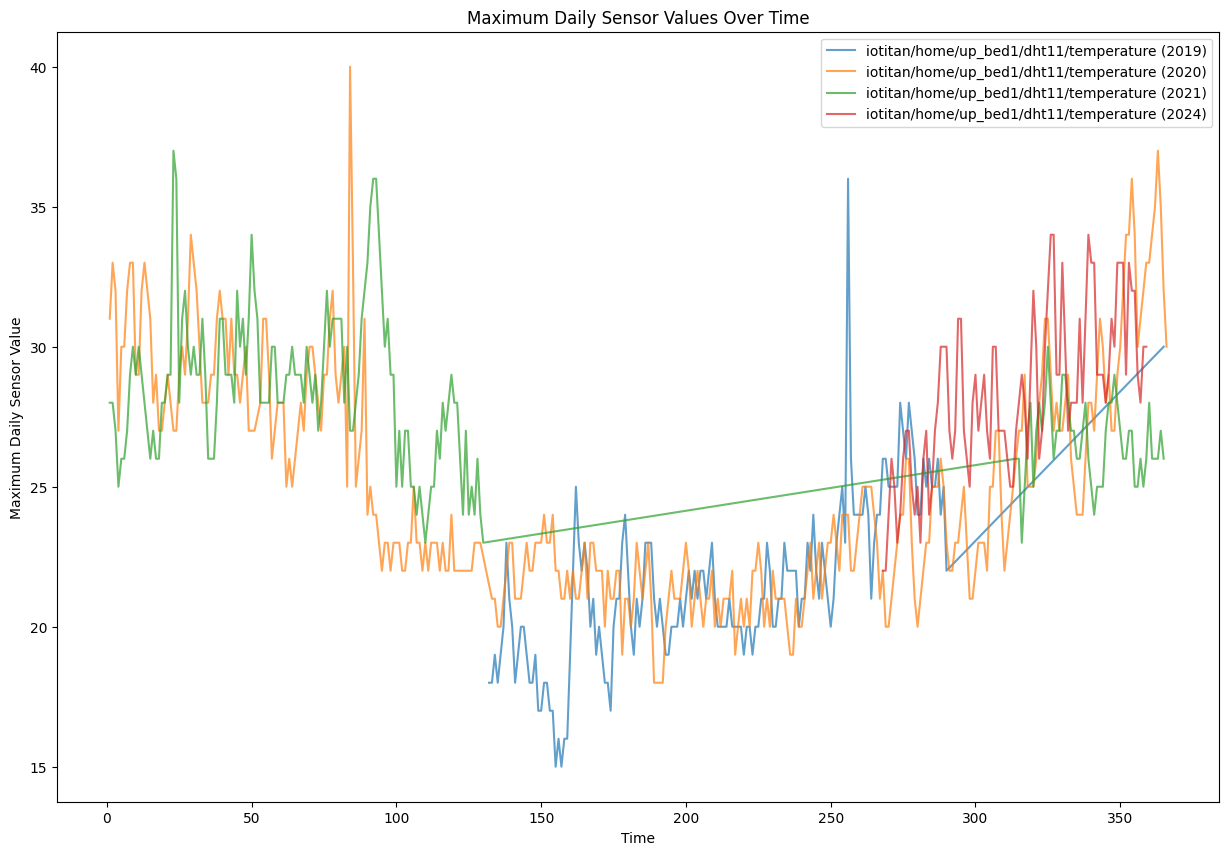

In [73]:
# Now partition the data by year


for sensor_name in sensor_names:
    if ('temperature' in sensor_name) and ('average' not in sensor_name):
        plt.figure(figsize=(15, 10))
        sensor_data = max_per_day_df[max_per_day_df['sensor_name'] == sensor_name]
        years = sensor_data['year'].unique()
        for year in years:
            year_data = sensor_data[sensor_data['year'] == year]
            plt.plot(year_data['day_of_year'], year_data['sensor_value'], label=f"{sensor_name} ({year})", alpha=0.7)

        plt.xlabel('Time')
        plt.ylabel('Maximum Daily Sensor Value')
        plt.title('Maximum Daily Sensor Values Over Time')
        plt.legend()
        plt.show()

# SMOOTHED MAX TEMPERATURE

In [91]:
#TODO: this does not work yet because I think the smoothing needs to be done per sensor name

In [85]:
def smooth(scalars: List[float], weight: float) -> List[float]:  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed


#ax.plot(x_labels, smooth(train_data, .9), label="Train Smooth")  # label="Train") # uncomment to reproduce figure below
#ax.plot(x_labels, train_data, label="Train")  # label="Train Smooth") # uncomment to reproduce figure below

In [88]:
max_per_day_df['smoothed'] = smooth(max_per_day_df['sensor_value'], 0.9)

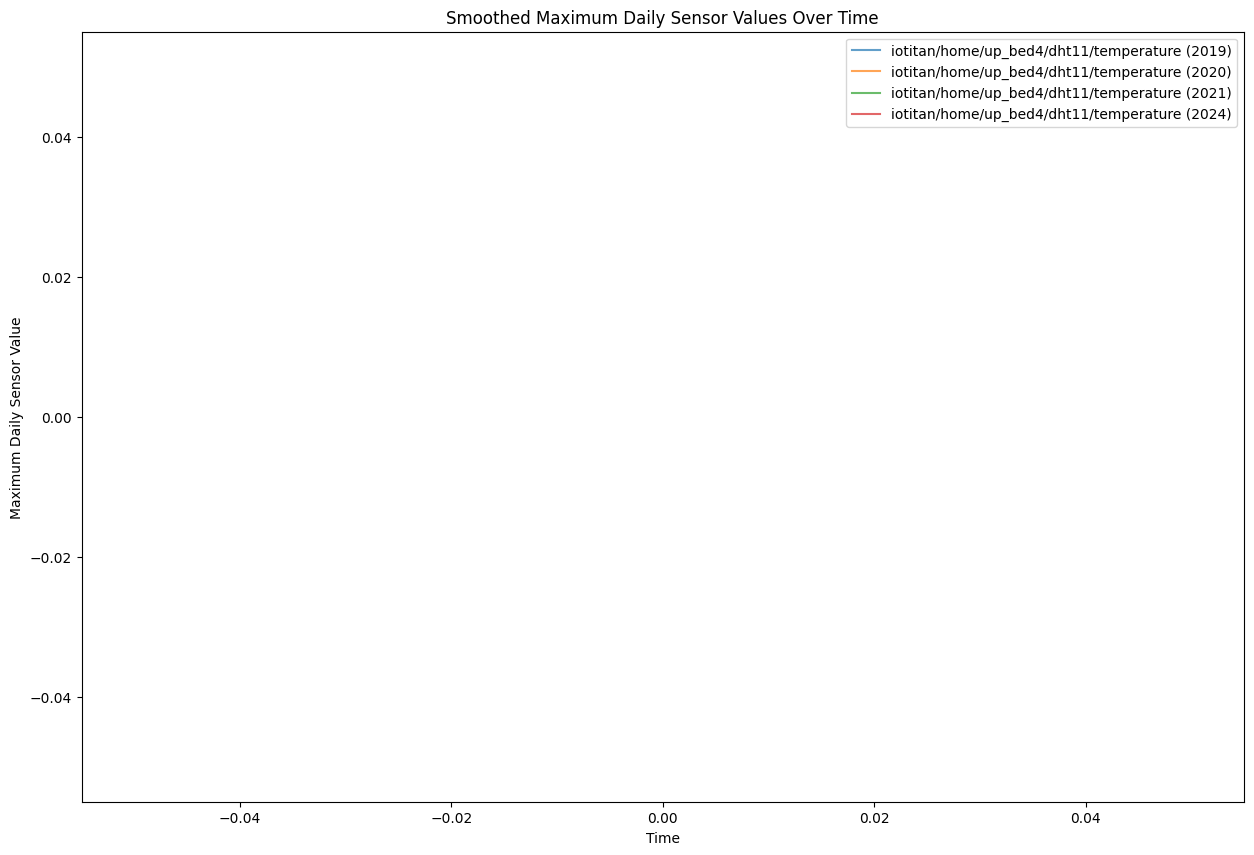

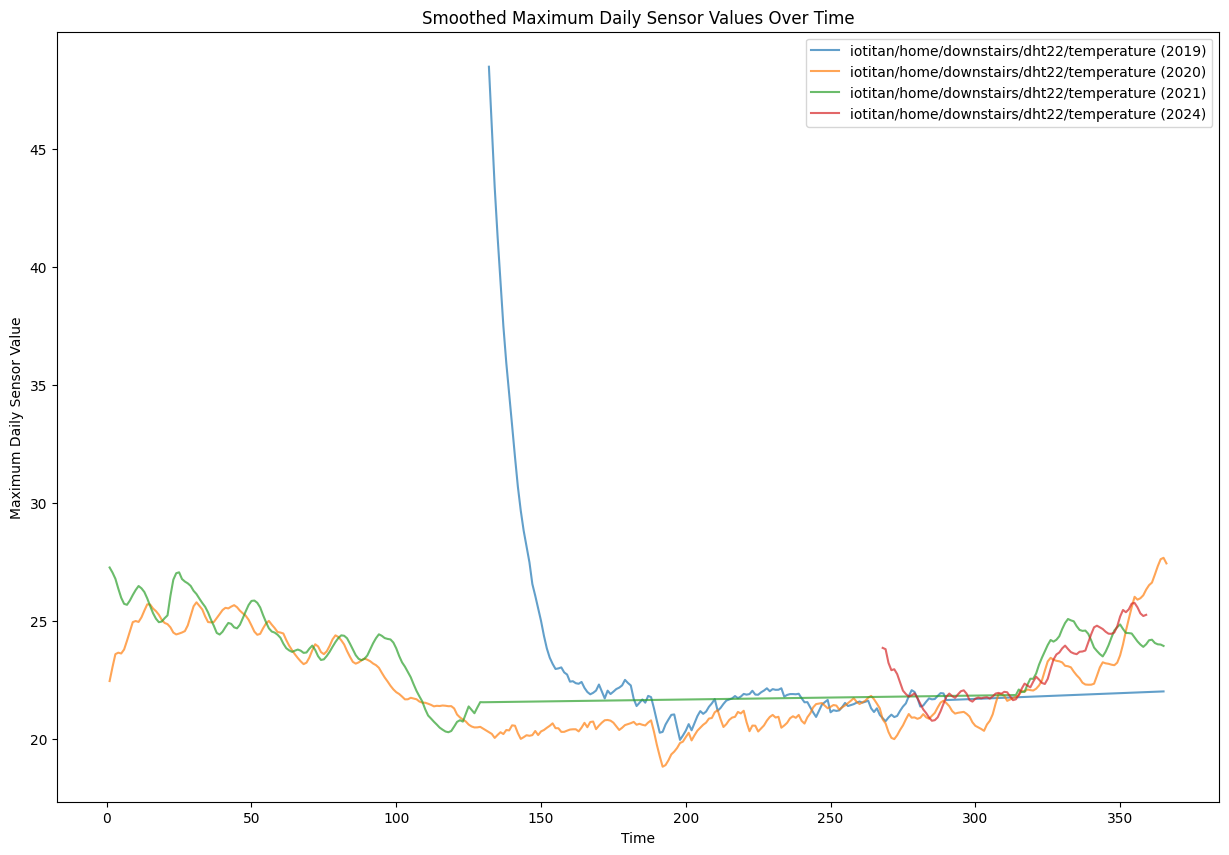

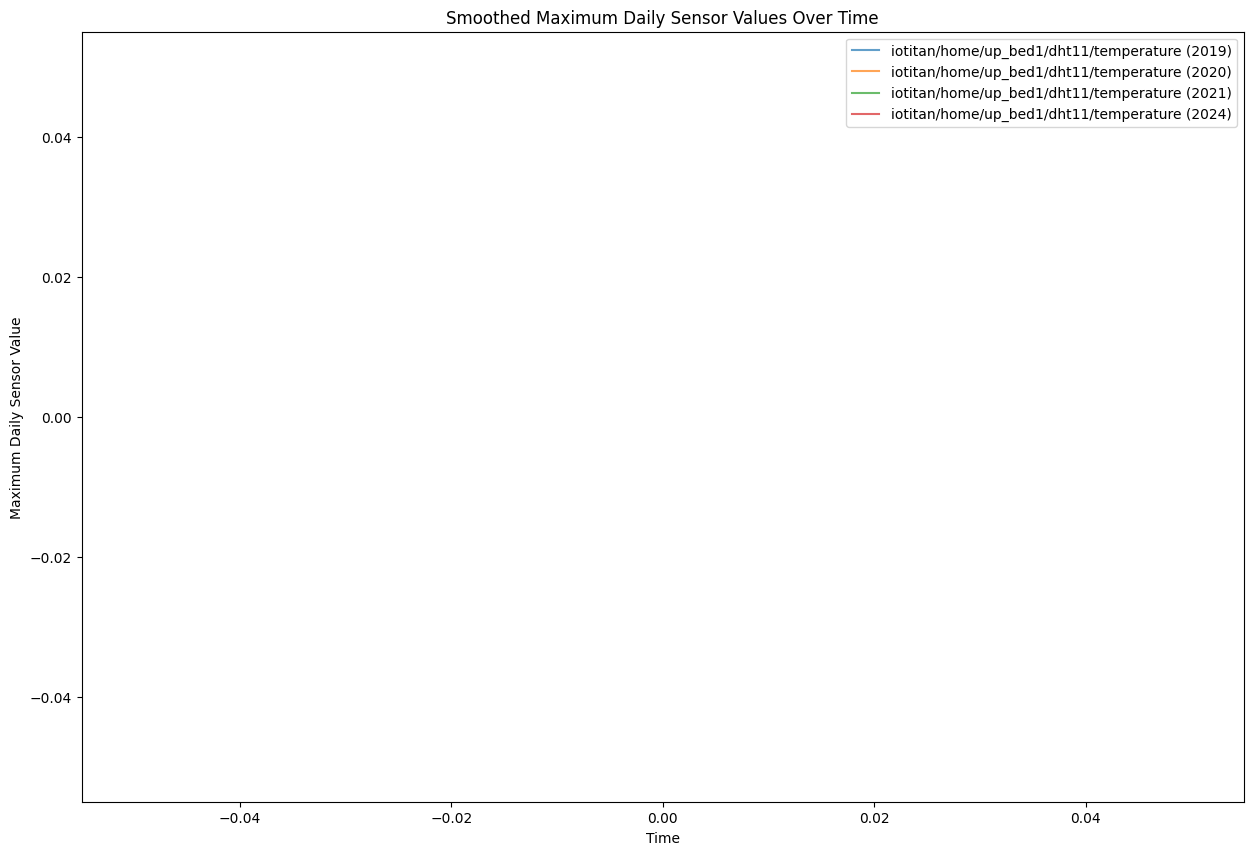

In [90]:
for sensor_name in sensor_names:
    if ('temperature' in sensor_name) and ('average' not in sensor_name):
        plt.figure(figsize=(15, 10))
        sensor_data = max_per_day_df[max_per_day_df['sensor_name'] == sensor_name]
        years = sensor_data['year'].unique()
        for year in years:
            year_data = sensor_data[sensor_data['year'] == year]
            plt.plot(year_data['day_of_year'], year_data['smoothed'], label=f"{sensor_name} ({year})", alpha=0.7)

        plt.xlabel('Time')
        plt.ylabel('Maximum Daily Sensor Value')
        plt.title('Smoothed Maximum Daily Sensor Values Over Time')
        plt.legend()
        plt.show()

# MIN TEMPERATURE

In [61]:
# Create a new dataframe of min value per day for each sensor
# Step 5: Group by 'sensor_name' and 'date' and calculate the max value per day
min_per_day_df = df.groupby(['sensor_name', 'year','day_of_year'])['sensor_value'].min().reset_index()

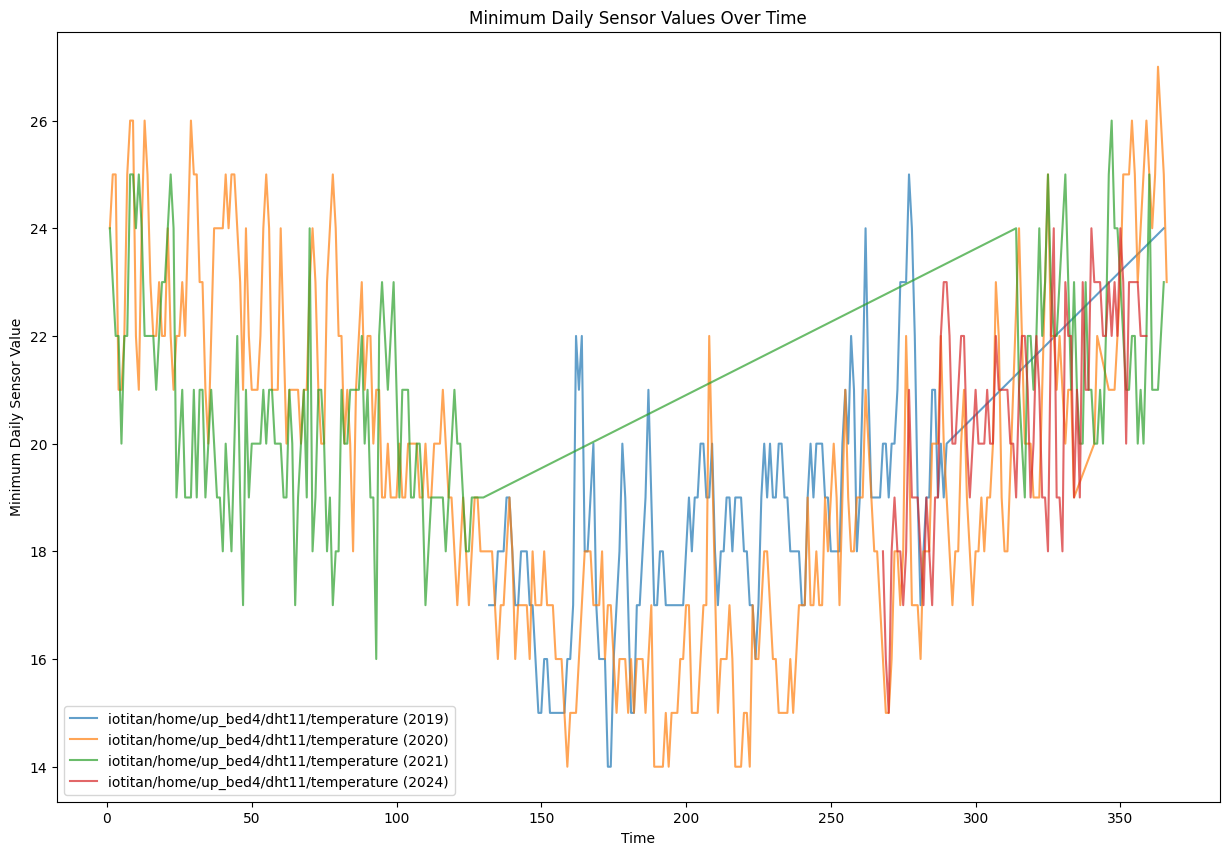

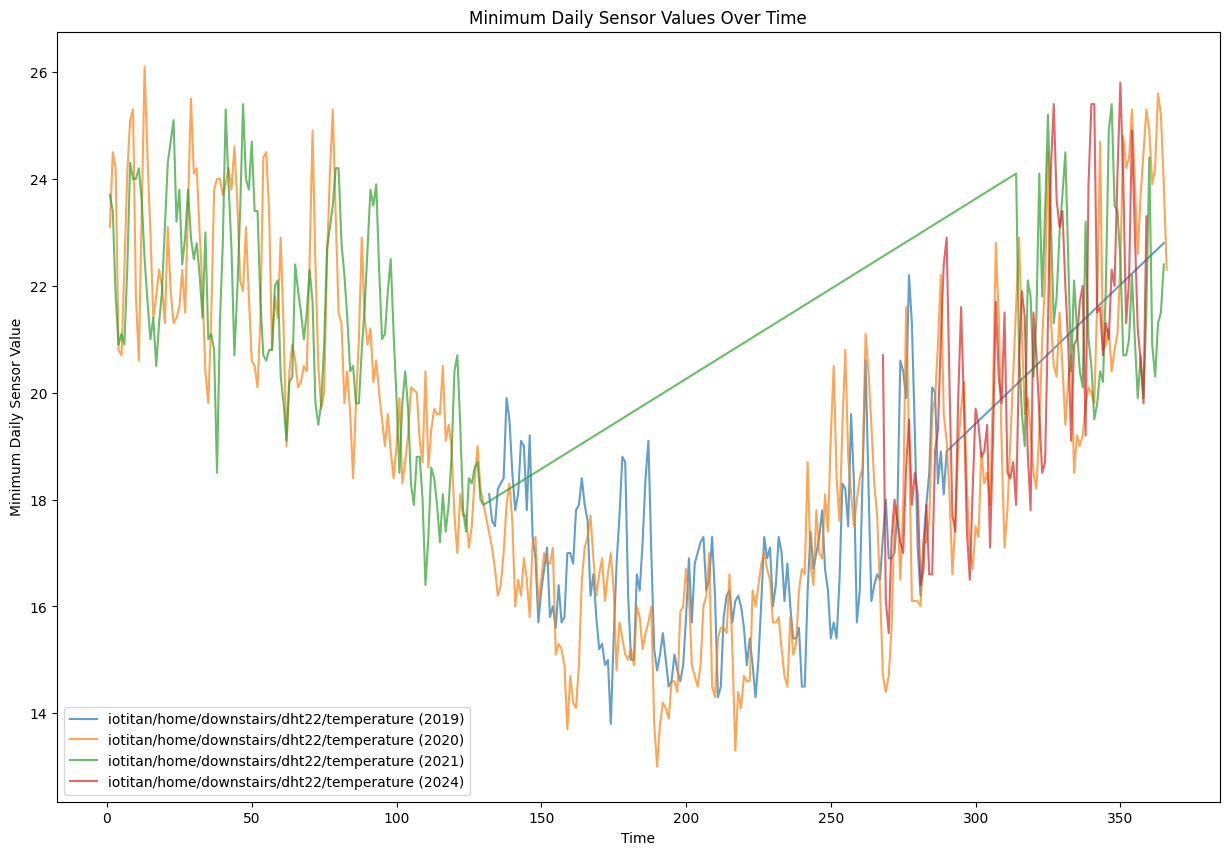

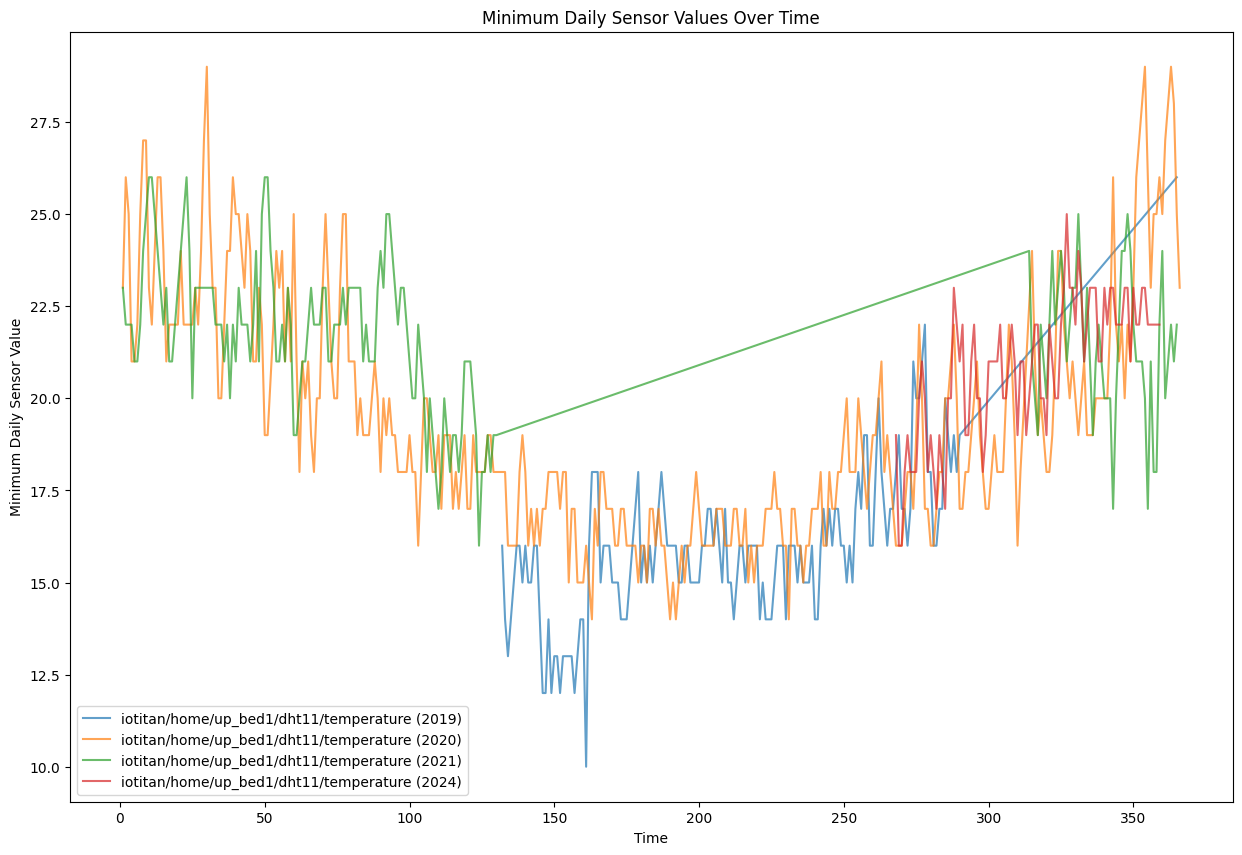

In [74]:
# Now partition the data by year
for sensor_name in sensor_names:
    if ('temperature' in sensor_name) and ('average' not in sensor_name):
        plt.figure(figsize=(15, 10))
        sensor_data = min_per_day_df[min_per_day_df['sensor_name'] == sensor_name]
        years = sensor_data['year'].unique()
        for year in years:
            year_data = sensor_data[sensor_data['year'] == year]
            plt.plot(year_data['day_of_year'], year_data['sensor_value'], label=f"{sensor_name} ({year})", alpha=0.7)

        plt.xlabel('Time')
        plt.ylabel('Minimum Daily Sensor Value')
        plt.title('Minimum Daily Sensor Values Over Time')
        plt.legend()
        plt.show()

# Radmon count per minute

iotitan/home/outside/radmon/cpm

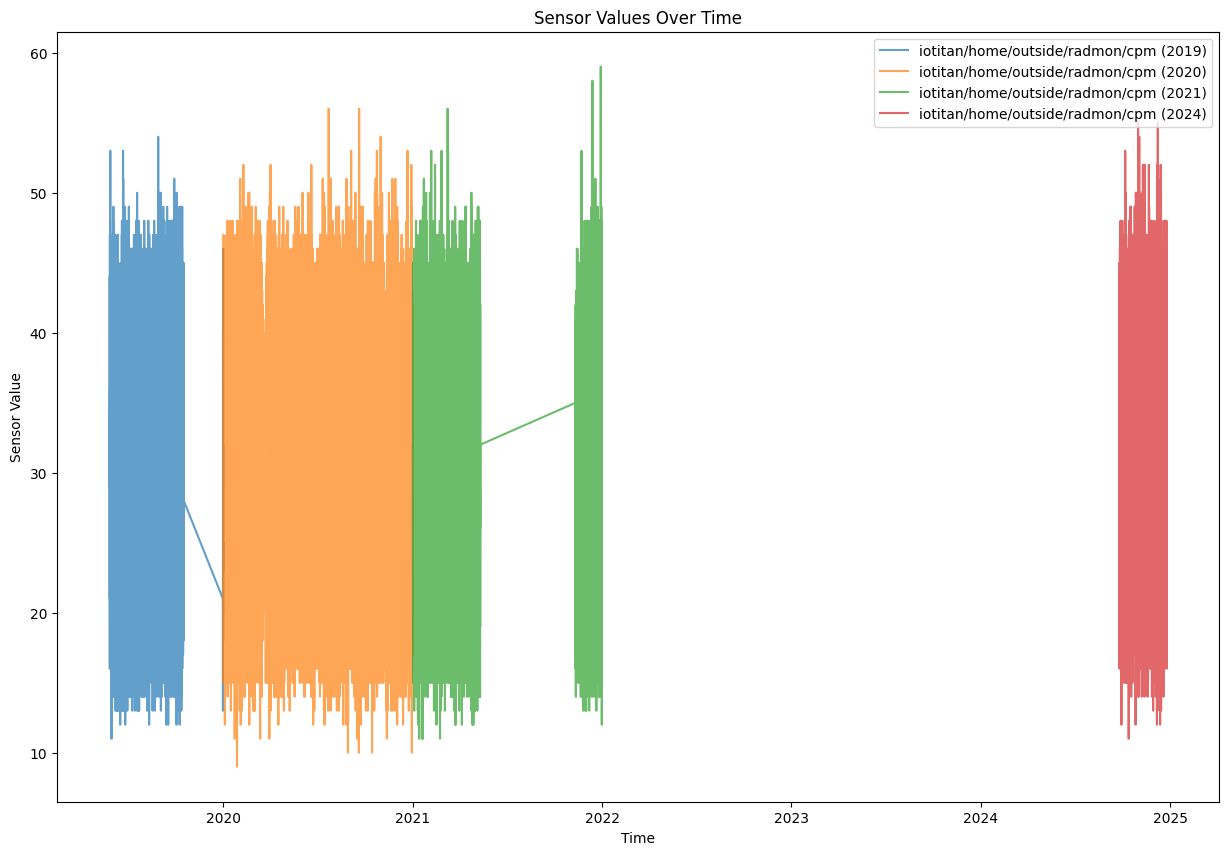

In [68]:
# Now partition the data by year
plt.figure(figsize=(15, 10))
for sensor_name in sensor_names:
    if (sensor_name == 'iotitan/home/outside/radmon/cpm'):
        sensor_data = df[df['sensor_name'] == sensor_name]
        years = sensor_data['year'].unique()
        for year in years:
            year_data = sensor_data[sensor_data['year'] == year]
            plt.plot(year_data['timestamp'], year_data['sensor_value'], label=f"{sensor_name} ({year})", alpha=0.7)

        plt.xlabel('Time')
        plt.ylabel('Sensor Value')
        plt.title('Sensor Values Over Time')
        plt.legend()
        plt.show()

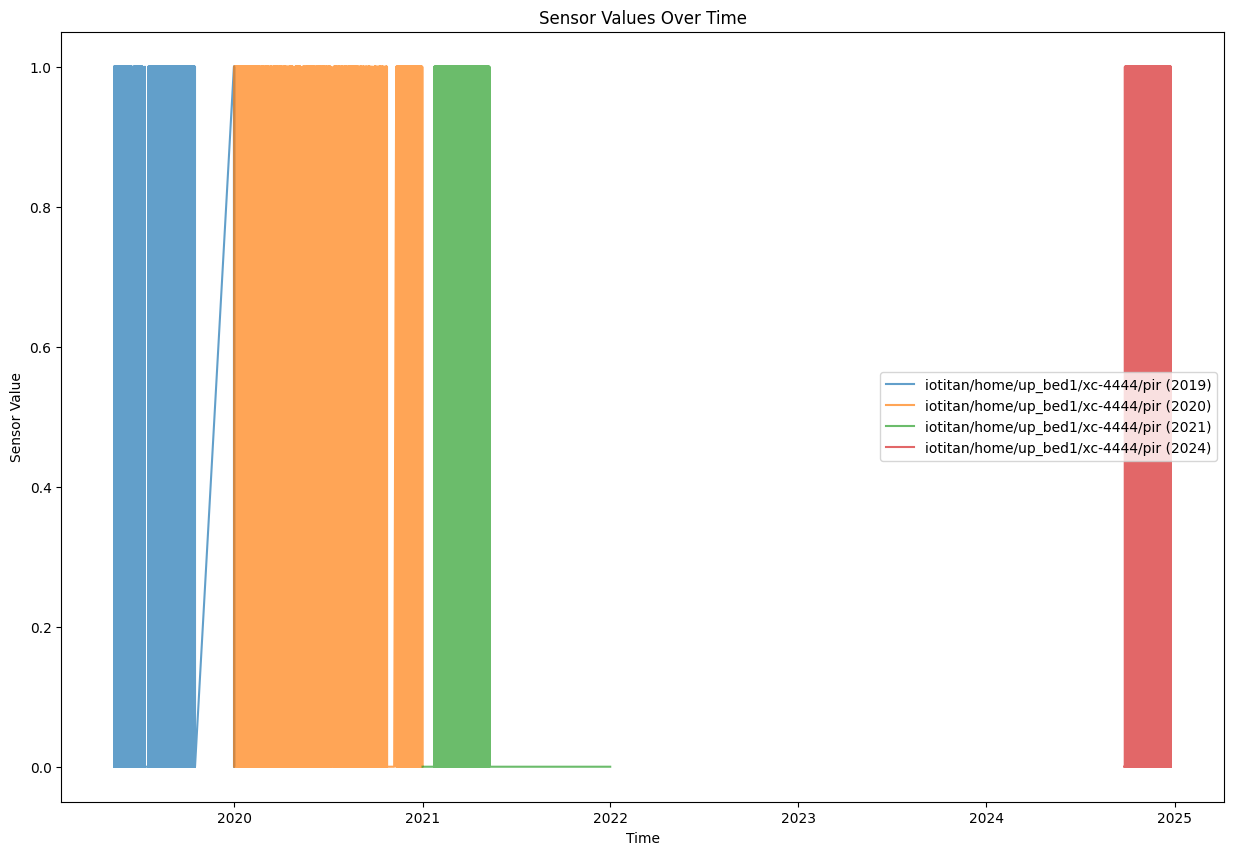

In [72]:
# Now partition the data by year
plt.figure(figsize=(15, 10))
for sensor_name in sensor_names:
    if (sensor_name == 'iotitan/home/up_bed1/xc-4444/pir'):
        sensor_data = df[df['sensor_name'] == sensor_name]
        years = sensor_data['year'].unique()
        for year in years:
            year_data = sensor_data[sensor_data['year'] == year]
            plt.plot(year_data['timestamp'], year_data['sensor_value'], label=f"{sensor_name} ({year})", alpha=0.7)

        plt.xlabel('Time')
        plt.ylabel('Sensor Value')
        plt.title('Sensor Values Over Time')
        plt.legend()
        plt.show()